In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import h, hbar, u, g, pi

import glob
import os
import pandas as pd
from scipy.optimize import minimize
import re

def str_to_list(s):
    s_sub = re.sub(r"(?<=[^\[])\s", ",", s)
    return eval(s_sub)

def order(ij):
    ij = np.array(ij)
    i = ij[..., 0]
    j = ij[..., 1]
    return np.where(np.sign(i) * np.sign(j) >= 0, np.abs(i + j), np.maximum(np.abs(i), np.abs(j)))

def order1d(ij):
    ij = np.array(ij)
    
    i = ij[..., 0]
    j = ij[..., 1]
    return np.where(np.sign(i) * np.sign(j) >= 0, np.abs(i + j), np.maximum(np.abs(i), np.abs(j))) * np.sign(ij[...,0])

def modsq(z):
    return z.real**2 + z.imag**2

In [2]:
URbDipole0 = -2.09931e-36  # at 1064
UKDipole0 = -1.83711e-36   # K39 at 1064
mRb = 86.909*u
mK = 39*u

def VRb(P, w0h, w0v):
    return np.abs(URbDipole0 * 2 * P / (np.pi * w0h * w0v))
def VK(P, w0h, w0v):
    return np.abs(UKDipole0 * 2 * P / (np.pi * w0h * w0v))

def ωxRb(P, w0h, w0v):
    return np.sqrt(4 * VRb(P, w0v, w0h) / (mRb * w0h**2))
def fxRb(P, w0h, w0v):
    return ωxRb(P, w0h, w0v) / (2*np.pi)



λlatt = 1064.5e-9
klatt = 2*np.pi / λlatt
# λlatt = 725e-9
ErRb = (h/λlatt)**2 / (2 * mRb)
ErK = (h/λlatt)**2 / (2 * mK)
ωrRb = ErRb / hbar
ωrK = ErK / hbar

#ωBlochRb = mRb * g / hbar
#ωBlochK = mK * g / hbar
#tBlochRb = 2*np.pi / ωBlochRb
#tBlochK = 2*np.pi / ωBlochK
tBlochRb = 2 * hbar * klatt / (mRb * g)
tBlochK = 2 * hbar * klatt / (mK * g)

In [3]:
V0 = 1
nmax = 15
karr = 2 * np.arange(-nmax, nmax+1)
q = 0

# M = np.diag(np.array([-V0/2]*(2*nmax+1)) + (q + karr) ** 2) +\
# np.diag([-V0/4]*(2*nmax), 1) +\
# np.diag([-V0/4]*(2*nmax), -1)

def H(q, V0):
    M = np.diag(np.array([-V0/2]*(2*nmax+1)) + (q + karr) ** 2) +\
    np.diag([-V0/4]*(2*nmax), 1) +\
    np.diag([-V0/4]*(2*nmax), -1)
    return M

def E1(q, V0):
    return np.linalg.eigvalsh(H(q, V0))

def Ψ1(q, V0):
    vecs = np.linalg.eigh(H(q, V0))[1]
    
    # change sign of eigenvectors so that the largest component with k>=0 is positive
    vpos = vecs[nmax:, :]
    maxpos = np.argmax(vpos, axis=0)
    maxvals = vpos[maxpos, np.arange(2*nmax+1)]
    sgn = np.sign(maxvals)
    sgn[sgn==0] = 1
    
    return (vecs * sgn).T
    #return vecs.T

#E = np.vectorize(E1, otypes=[np.ndarray])
E = np.vectorize(E1, signature='(),()->(n)')
Ψ = np.vectorize(Ψ1, signature='(),()->(n,n)')

def KapitzaDirac1(k_BEC, V0, t_pulse):    
    # free BEC coefficients in momentum basis
    v0 = np.zeros(2*nmax+1)
    
    #q_BEC = (k_BEC + 0.5) % 1 - 0.5
    q_BEC = (k_BEC + 1) % 2 - 1
    #q_BEC = (k_BEC + 1 - 10*np.finfo(float).eps) % 2 - 1
    
    G_BEC = int(np.round(k_BEC - q_BEC))
    
    # account for nonzero k_BEC
    v0[nmax + G_BEC//2] = 1
    
    M = Ψ(q_BEC, V0=V0) # use eigenvectors as unitary operator to convert from free space to Bloch waves
    ω = E(q_BEC, V0=V0) # use eigenenergies for time evolution
    c = M @ v0          # project free space onto Bloch waves
    ct = c * np.exp(-1j*ω*t_pulse) # time evolution in Bloch state
    vt = np.conj(M).T @ ct         # project back to free space
    
    return vt

KapitzaDirac = np.vectorize(KapitzaDirac1, signature='(),(),()->(n)')

# KD Fitting

In [4]:
folder = r"Z:\Shared\Kagome\Data\2022\01\27\it_K39_Lattice_KD"  #r"Z:\Shared\Kagome\Data\2021\06\09\it_Rb_Z_Lattice"
time = "11_37_31" #"20_59_55" #"12_52_47"
files = glob.glob(os.path.join(folder, time)+"*Gauss2DFit*order.txt")

In [5]:
files

[]

In [17]:
int(os.path.splitext(os.path.split(f)[-1])[0].split("_")[-2])

0

In [21]:
#df = pd.DataFrame()
wavelength = 532
df_list = []
orders = []
index_list = []
for f in files:
    with open(f, 'r') as file:
        #order = int(os.path.splitext(os.path.split(f)[-1])[0].split("_")[-2][:-2])
        order = int(os.path.splitext(os.path.split(f)[-1])[0].split("_")[-2])
        if wavelength == 532:
            order = order//2
        s = file.readlines()
        varnames = s[3]
        data = np.array([eval(line) for line in s[4:]])
        orders.append(order)
        index = data[:, 0]
        index_list.append(index * 1e6)
        
with open(files[0], 'r') as file:
    s = file.readlines()
    data = np.array([eval(line) for line in s[4:]])
    index_list.append(data[:, 0] * 1e6)#.astype(float)

index = np.sort(np.unique([e for l in index_list for e in l]))

df = pd.DataFrame(index=index, columns=orders)
df.sort_index(inplace=True)

for f in files:
    with open(f, 'r') as file:
        #order = os.path.splitext(os.path.split(f)[-1])[0].split("_")[-2]
        # order = int(os.path.splitext(os.path.split(f)[-1])[0].split("_")[-2][:-2])
        order = int(os.path.splitext(os.path.split(f)[-1])[0].split("_")[-2])
        if wavelength == 532:
            order = order//2
        s = file.readlines()
        varnames = s[3][1:-2].split(',')
        data = np.array([eval(line) for line in s[4:]])
        df.loc[data[:, 0] * 1e6, order] = data[:, 1]

In [22]:
df

,0,1,-1
10.0,19859.665194,3708.838646,3950.00863
13.0,16256.293823,4736.892682,5073.840794
16.0,13741.395917,5530.743848,5600.973684
19.0,16936.041,4453.398333,5240.880329
22.0,21986.708353,4099.435742,4269.248215
25.0,22315.111595,2187.060855,2560.242289
28.0,35107.012059,903.922996,1043.561804
31.0,32811.776349,149.505744,393.841104
34.0,34776.659678,552.853805,400.564188
37.0,28437.553344,934.087468,937.636367


In [31]:
bg_val = 0
df_offset = df - bg_val
df_norm = (df_offset.T / df_offset.sum(axis=1)).T

k_BEC = 0

zerocol = df_norm.columns.get_loc(0) # locate zero order
data_norm_arr = df_norm.values.astype(float)
ysize = np.sum(np.isfinite(data_norm_arr))
def chisq_norm(params):
    V0, ratio = params
    data_pred = np.abs(KapitzaDirac(k_BEC, V0, df.index.values * ωrRb / 1e6)[:, nmax + np.array(orders)])**2
    chi2 = np.nansum((data_norm_arr - ratio * data_pred)**2)
    #print("{:.6f},\t{:.3g}:\t\t{:.9g}".format(V0, ratio, chi2))
    return chi2

def chisq_norm_1(params):
    V0, = params
    ratio = 1
    data_pred = np.abs(KapitzaDirac(k_BEC, V0, df.index.values * ωrRb / 1e6)[:, nmax + np.array(orders)])**2
    chi2 = np.nansum((data_norm_arr - ratio * data_pred)**2)
    #print("{:.6f},\t{:.3g}:\t\t{:.9g}".format(V0, ratio, chi2))
    return chi2

def chisq_norm_2(params):
    V0, undiffracted = params
    data_pred = np.abs(KapitzaDirac(k_BEC, V0, df.index.values * ωrRb / 1e6)[:, nmax + np.array(orders)])**2
    chi2 = np.nansum((data_norm_arr - ratio * data_pred)**2)
    #print("{:.6f},\t{:.3g}:\t\t{:.9g}".format(V0, ratio, chi2))
    return chi2

## Unnormalised fit

In [32]:
data_arr = df.values
def chisq(params):
    V0, ratio = params
    data_pred = np.abs(KapitzaDirac(k_BEC, V0, df.index.values * ωrRb / 1e6)[:, nmax + np.array(orders)])**2
    chi2 = np.nansum((data_arr - ratio * data_pred)**2)
    #print("{:},\t{:.3g}:\t\t{:.9g}".format(V0, ratio, chi2))
    return chi2

## Normalised fit

In [33]:
sol = minimize(chisq_norm, x0=[20, 0.8])

In [35]:
sol.x
V0, ratio = sol.x
V0err, ratioerr = np.sqrt(np.diag(sol.hess_inv))
# V0, = sol.x
# s_sq = sol.fun / (ysize - sol.x.shape[0])
# pcov = sol.hess_inv * s_sq


# V0err, = np.sqrt(np.diag(pcov))
ratio = 1
ratioerr = 0
print(V0err)

3.54752744512956


In [56]:
#order = 0
t_pulse = np.linspace(0, df_norm.index.max(), 200) * ωrRb / 1e6

data_fit = ratio * np.abs(KapitzaDirac(k_BEC, V0, t_pulse))**2
data_fit_plus = ratio * np.abs(KapitzaDirac(k_BEC, V0 + V0err, t_pulse))**2

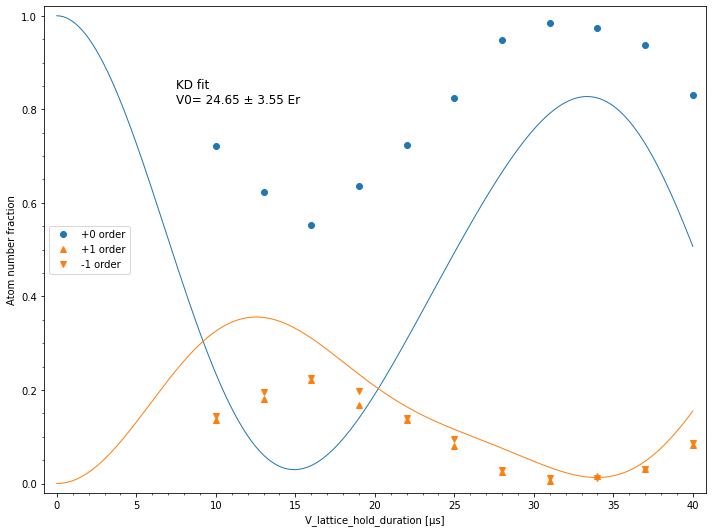

In [63]:
plot_together = True

if plot_together:
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot()
else:
    fig = plt.figure(figsize=(8,12))
    nplots = np.max(np.abs(orders)) + 1
    axs = [fig.add_subplot(nplots, 1, j+1) for j in range(nplots)]

idx_arr = np.argsort(np.abs(orders) - 0.1 * np.sign(orders))
for j, order in enumerate(np.array(orders)[idx_arr]):
    if not plot_together and order >= 0:
        #fig = plt.figure(figsize=(8,3))
        #ax = fig.add_subplot()
        ax = axs[np.abs(order)]
    #ax.plot(t_pulse / ωrRb * 1e6, np.abs(vt[:, nmax + order])**2);
    #ax2 = ax.twinx()
    #color = 'C{:}'.format(nmax+order)
    color = 'C{:}'.format(np.abs(order))
    mkr = '^' if order>0 else 'v' if order <0 else 'o'
    ax.plot(df_norm[order], linestyle='None', marker=mkr, color=color, label="{:+d} order".format(order))
    if order >= 0: # or not plot_together:
        ax.plot(t_pulse / ωrRb * 1e6, data_fit[:, nmax+order], color=color, lw=1)#, label="KD fit\nV0= {:.1f} ± {:.1f} Er\nr  = {:.2f} ± {:.2f}".format(V0, V0err, ratio, ratioerr))
    #ax.set_xlabel(r"t / us");
    #ax.set_ylabel("Atom number")
    if plot_together:
        ax.set_ylabel("Atom number fraction")
    #ax.set_ylabel(varnames[1])
    ax.legend()
    ax.margins(0.02)
    ax.minorticks_on()
    
#ax.set_xlabel(varnames[0])
ax.set_xlabel("V_lattice_hold_duration [μs]")
    
if plot_together:
    # ax.annotate("KD fit\nV0= {:.1f} ± {:.1f} Er\nr  = {:.2f} ± {:.2f}".format(V0, V0err, ratio, ratioerr), (0.2, 0.8), 
    #             xycoords='axes fraction', fontsize='large')  #, fontweight='light')
    ax.annotate("KD fit\nV0= {:.2f} ± {:.2f} Er".format(V0, V0err), (0.2, 0.8), 
                xycoords='axes fraction', fontsize='large')  #, fontweight='light')


    # fig.savefig(os.path.splitext(files[j])[0]+"_KD_fit.png", dpi=300)
    fig.tight_layout()
    # fig.savefig(os.path.join(folder, time)+"_KD_fit.png", dpi=300)

else:
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("KD fit\nV0= {:.2f} ± {:.2f} Er".format(V0, V0err))
    #fig.savefig(os.path.join(folder, time)+"_KD_fit_subplots.png", dpi=300)
    

# 1D KD fitting new

In [29]:
# folder = r"Z:\Shared\Kagome\Data\2021\12\08\luca_test"  #r"Z:\Shared\Kagome\Data\2021\06\09\it_Rb_Z_Lattice"
# fname = r"14_33_10_frac_1_0,0_frac_1_1,-1_frac_1_-1,1(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
# fname = r"14_50_08_frac_1_0,0_frac_1_1,0_frac_1_-1,0(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
# fname = r"15_04_13_frac_1_0,0_frac_1_1,0_frac_1_-1,0(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
# folder = r"Z:\Shared\Kagome\Data\2021\06\18\luca_test"
#fname = r"18_54_53_num_0_num_1_num_-1_num_2_num_-2_num_3_num_-3(PeakPopulationFit)_vs_V_lattice_hold_duration.txt"
# fname = r"18_54_53_frac_0_frac_1_frac_-1_frac_2_frac_-2_frac_3_frac_-3(PeakPopulationFit)_vs_V_lattice_hold_duration.txt"
folder = r"Z:\Shared\Kagome\Data\2022\02\14\it_K39_Lattice_KD"
fname = r"11_31_24_frac_1_frac_0_frac_-1_frac_2_frac_-2(PeakPopulationFit)_vs_Lattice_hold_duration.txt"

with open(os.path.join(folder, fname), 'r') as file:
    s = file.readlines()
    varnames = s[3]
    nan = np.nan
    data = np.array([eval(line) for line in s[4:]])
#     orders = [tuple(int(n) for n in re.findall(r'.+\/(.+)_([^\s]+)\s*\[\s*\]', s)[0]) for s in varnames[1:-2].split(",")[1:]]
#     orders1d = order1d(orders)
    orders1d = [tuple(int(n) for n in re.findall(r'.+\/([^\s]+)\s*\[\s*\]', s))[0] for s in varnames[1:-2].split(",")[1:]]
    df = pd.DataFrame(data[:, 1:], columns=orders1d, index=pd.Index(data[:,0]*1e6, name='t'))

time = re.findall(r'([0-9]{2}_[0-9]{2}_[0-9]{2})',fname)[0]
#display(df.head(), df.plot(marker='.', linestyle='None'));

<AxesSubplot:xlabel='t'>

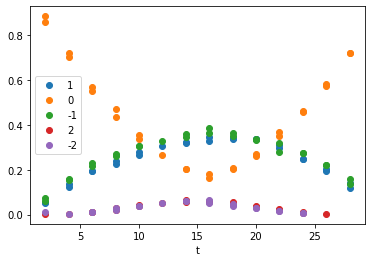

In [31]:
%matplotlib inline
df.plot(linestyle='None', marker='o')

In [40]:
data_arr = df.values
#t_arr = df.index.values * ωrRb / 1e6
t_arr = df.index.values * ωrK / 1e6
cols = df.columns.values
# ODmeas = lambda OD, cont: -np.log(np.exp(-OD) * (1-cont) + cont)
mult = 3/4 # vertical 1064: 1, horizontal 1064: 3/4, horizontal 532: 3
k0 = 0  # .1
def chisq(params):
    #V0, active = params
    active = 1
    t0 = 1
    V0, = params #n, cont = params
    #data_pred = active * modsq(KapitzaDirac(k0, V0/mult, mult*(t_arr + t0)))[:, nmax + cols] + (1-active) * (cols==0)
    data_pred = modsq(KapitzaDirac(0, V0/mult, mult*(t_arr)))[:, nmax + cols]
    #func = lambda x: ODmeas(x, cont)
    #func = lambda x: x
    #data_pred = n * func(modsq(KapitzaDirac(k0, V0/mult, mult*(t_arr + t0))))[:, nmax + cols]
    chi2 = np.nansum((data_pred - data_arr)**2)
    return chi2
sol = minimize(chisq, x0=[16.])  # x0=[16, 1, 0.1])
# V0, n, cont = sol.x
V0, = sol.x
t0 = 0
active = 1
activeerr = np.nan
t0err = np.nan
V0err, = np.sqrt(np.diag(sol.hess_inv)) # * np.linalg.det(sol.hess_inv))  # 
# V0err = np.nan
print("V0 = {:.1f} ± {:.1f} Er".format(V0, V0err))
# print("V0 = {:.1f} ± {:.1f} Er1064".format(V0/np.sqrt(3), V0err/np.sqrt(3)))
print("active = {:.3f} ± {:.3f} Er".format(active, activeerr))
print("t0 = {:.3f} ± {:.3f} Er".format(t0, t0err))
print(sol.message)

V0 = 9.1 ± 1.3 Er
active = 1.000 ± nan Er
t0 = 0.000 ± nan Er
Optimization terminated successfully.


In [35]:
sol

      fun: 0.35792197963349287
 hess_inv: array([[1.78529012]])
      jac: array([-1.14366412e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([9.05656539])

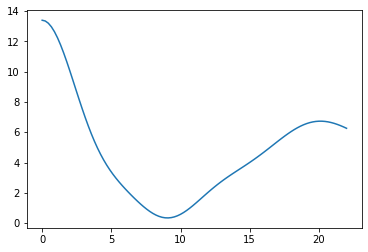

In [36]:
y = np.linspace(0, 22, 100).reshape(-1,1)

%matplotlib inline
plt.plot(y, np.vectorize(chisq, signature="(1)->()")(y))

In [41]:
plot_together = True
%matplotlib widget
t_pulse = np.linspace(0, df.index.max(), 200) * ωrK / 1e6

# V0 = 8# 15.6 #17.5
# t0 = 0
active = 1
k0 = 0
# k0 = 0.
# n = 15e3
cont = 0  # 0.02
# mult = 3 #3/4  # 3

func = lambda x: x
# func = lambda x: x**(1.1)
# trueOD = lambda ODmeas, ODmax: -np.log((np.exp(-ODmeas)-np.exp(-ODmax))/(1-np.exp(-ODmax)))
# func = lambda x: trueOD(x, 1.1)
#ODmeas = lambda OD, cont: -np.log(np.exp(-OD) * (1-cont) + cont)
# func = lambda x: ODmeas(x, cont)

#data_fit = active * modsq(KapitzaDirac(k0, V0/mult, mult*(t_pulse + t0))) + (1-active) * (karr==0)
data_fit = modsq(KapitzaDirac(0, V0/mult, mult*(t_pulse)))
# data_fit = n * func(modsq(KapitzaDirac(k0, V0/mult, mult*(t_pulse + t0))))
# data_fit_plus = modsq(KapitzaDirac(0, V0 + V0err, t_pulse))

if plot_together:
    fig = plt.figure(figsize=(8,6))   # (10, 7.5)
    ax = fig.add_subplot()
else:
    fig = plt.figure(figsize=(8,12))
    nplots = np.max(np.abs(orders1d)) + 1
    axs = [fig.add_subplot(nplots, 1, j+1) for j in range(nplots)]

idx_arr = np.argsort(np.abs(orders1d) - 0.1 * np.sign(orders1d))
for j, order in enumerate(np.array(orders1d)[idx_arr]):
    if not plot_together and order >= 0:
        #fig = plt.figure(figsize=(8,3))
        #ax = fig.add_subplot()
        ax = axs[np.abs(order)]
    #ax.plot(t_pulse / ωrRb * 1e6, np.abs(vt[:, nmax + order])**2);
    #ax2 = ax.twinx()
    #color = 'C{:}'.format(nmax+order)
    color = 'C{:}'.format(np.abs(order))
    mkr = '^' if order>0 else 'v' if order <0 else 'o'
    ax.plot(df[order], linestyle='None', marker=mkr, color=color, label="{:+d} order".format(order))
    #if order >= 0: # or not plot_together:
    if True:
        ax.plot(t_pulse / ωrK * 1e6, data_fit[:, nmax+order], color=color, lw=1)#, label="KD fit\nV0= {:.1f} ± {:.1f} Er\nr  = {:.2f} ± {:.2f}".format(V0, V0err, ratio, ratioerr))
    #ax.set_xlabel(r"t / us");
    #ax.set_ylabel("Atom number")
    if plot_together:
        ax.set_ylabel("Atom number fraction")
    #ax.set_ylabel(varnames[1])
    ax.legend()
    ax.margins(0.02)
    ax.minorticks_on()
    
#ax.set_xlabel(varnames[0])
ax.set_xlabel("V_lattice_hold_duration [μs]")
    
if plot_together:
#     ax.annotate("KD fit\nV0= {:.1f} ± {:.1f} Er".format(V0, V0err), (0.3, 0.8), 
#                 xycoords='axes fraction', fontsize='large')
    # ax.annotate("KD fit\nV0= {:.1f} ± {:.1f} Er\nr  = {:.2f} ± {:.2f}".format(V0, V0err, ratio, ratioerr), (0.2, 0.8), 
    #            xycoords='axes fraction', fontsize='large')  #, fontweight='light')
    # ax.annotate("KD fit\n$V_0$ = {:.2f} ± {:.2f} Er1064\nactive = {:.3f} ± {:.3f}\n$t_0$ = {:.3f} ± {:.3f} μs".format(V0, V0err, active, activeerr, t0 * 1e6/ωrK, t0err * 1e6/ωrK), (0.2, 0.8), 
    #            xycoords='axes fraction', fontsize='large')  #, fontweight='light')
    ax.annotate("$V_0$ = {:.1f} Er1064".format(V0), (0.3, 0.8), 
              xycoords='axes fraction', fontsize='large')  #, fontweight='light')


    # fig.savefig(os.path.splitext(files[j])[0]+"_KD_fit.png", dpi=300)
    fig.tight_layout()
#     fig.savefig(os.path.join(folder, time)+"_KD_fit.png", dpi=300)

else:
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    # fig.suptitle("KD fit\nV0= {:.2f} ± {:.2f} Er\nactive= {:.3f} ± {:.3f}".format(V0, V0err, active, activeerr))
    fig.suptitle("KD fit\nV0= {:.2f} ± {:.2f} Er".format(V0, V0err))
    # fig.suptitle("KD fit\nV0= {:.2f} ± {:.2f} Er".format(V0, V0err, active, activeerr))
    # fig.savefig(os.path.join(folder, time)+"_KD_fit_subplots.png", dpi=300)
    
# %matplotlib inline

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
V0/np.sqrt(3)

9.237604307034013

# 1D KD summing plus and minus orders

In [105]:
# folder = r"Z:\Shared\Kagome\Data\2021\12\08\luca_test"  #r"Z:\Shared\Kagome\Data\2021\06\09\it_Rb_Z_Lattice"
# fname = r"14_33_10_frac_1_0,0_frac_1_1,-1_frac_1_-1,1(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
# fname = r"14_50_08_frac_1_0,0_frac_1_1,0_frac_1_-1,0(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
# fname = r"15_04_13_frac_1_0,0_frac_1_1,0_frac_1_-1,0(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
# folder = r"Z:\Shared\Kagome\Data\2021\06\18\luca_test"
#fname = r"18_54_53_num_0_num_1_num_-1_num_2_num_-2_num_3_num_-3(PeakPopulationFit)_vs_V_lattice_hold_duration.txt"
# fname = r"18_54_53_frac_0_frac_1_frac_-1_frac_2_frac_-2_frac_3_frac_-3(PeakPopulationFit)_vs_V_lattice_hold_duration.txt"
# folder = r"Z:\Shared\Kagome\Data\2022\01\12\it_K39_Lattice_KD"
# fname = r"19_16_02_frac_0_frac_1_frac_-1_frac_2_frac_-2(PeakPopulationFit)_vs_Lattice_hold_duration.txt"
folder = r"Z:\Shared\Kagome\Data\2022\02\01\it_K39_Lattice_KD"
fname = r"14_39_43_frac_0_frac_1_frac_-1(PeakPopulationFit)_vs_Lattice_hold_duration.txt"

with open(os.path.join(folder, fname), 'r') as file:
    s = file.readlines()
    varnames = s[3]
    nan = np.nan
    data = np.array([eval(line) for line in s[4:]])
#     orders = [tuple(int(n) for n in re.findall(r'.+\/(.+)_([^\s]+)\s*\[\s*\]', s)[0]) for s in varnames[1:-2].split(",")[1:]]
#     orders1d = order1d(orders)
    orders1d = [tuple(int(n) for n in re.findall(r'.+\/([^\s]+)\s*\[\s*\]', s))[0] for s in varnames[1:-2].split(",")[1:]]
    df = pd.DataFrame(data[:, 1:], columns=orders1d, index=pd.Index(data[:,0]*1e6, name='t'))

#display(df.head(), df.plot(marker='.', linestyle='None'));

In [106]:
# aggregate plus and minus
df = df.groupby(np.abs, axis=1).agg(np.nanmean)
# average datapoints at each time
df = df.groupby(level=0).agg(np.nanmean)
orders1d = [x for x in orders1d if x>=0]

tot = 2*df.sum(axis=1)-df[0]

df = df.divide(tot, axis='rows')

In [107]:
data_arr = df.values
#t_arr = df.index.values * ωrRb / 1e6
t_arr = df.index.values * ωrK / 1e6
cols = df.columns.values
mult = 3
def chisq(params):
    #V0, active = params
    # active = 1
    V0 = params
    data_pred = active * modsq(KapitzaDirac(0, V0/mult, mult*(t_arr + t0)))[:, nmax + cols] + (1-active) * (cols==0)
    chi2 = np.nansum((data_pred - data_arr)**2)
    return chi2
sol = minimize(chisq, x0=[18])
V0, = sol.x
active = 1
activeerr = np.nan
t0 = 0
t0err = np.nan
V0err, = np.sqrt(np.diag(sol.hess_inv))
print("V0 = {:.1f} ± {:.1f} Er".format(V0, V0err))
print("V0 = {:.1f} ± {:.1f} Er1064".format(V0/np.sqrt(3), V0err/np.sqrt(3)))
print("active = {:.3f} ± {:.3f} Er".format(active, activeerr))
print("t0 = {:.3f} ± {:.3f} Er".format(t0, t0err))

V0 = 16.0 ± 2.3 Er
V0 = 9.2 ± 1.3 Er1064
active = 1.000 ± nan Er
t0 = 0.000 ± nan Er


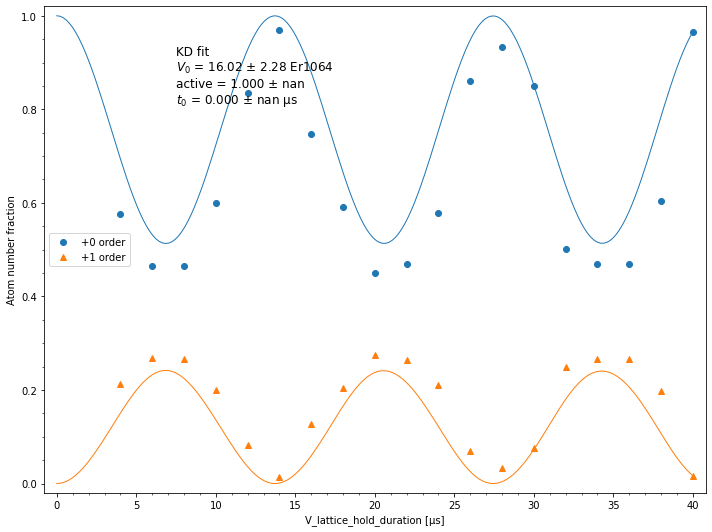

In [108]:
plot_together = True

t_pulse = np.linspace(0, df.index.max(), 200) * ωrK / 1e6

# V0 = 17.5 #17.5
# t0 = 0
active = 1

data_fit = active * modsq(KapitzaDirac(0, V0/mult, mult*(t_pulse + t0))) + (1-active) * (karr==0)
# data_fit_plus = modsq(KapitzaDirac(0, V0 + V0err, t_pulse))

if plot_together:
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot()
else:
    fig = plt.figure(figsize=(8,12))
    nplots = np.max(np.abs(orders1d)) + 1
    axs = [fig.add_subplot(nplots, 1, j+1) for j in range(nplots)]

idx_arr = np.argsort(np.abs(orders1d) - 0.1 * np.sign(orders1d))
for j, order in enumerate(np.array(orders1d)[idx_arr]):
    if not plot_together and order >= 0:
        #fig = plt.figure(figsize=(8,3))
        #ax = fig.add_subplot()
        ax = axs[np.abs(order)]
    #ax.plot(t_pulse / ωrRb * 1e6, np.abs(vt[:, nmax + order])**2);
    #ax2 = ax.twinx()
    #color = 'C{:}'.format(nmax+order)
    color = 'C{:}'.format(np.abs(order))
    mkr = '^' if order>0 else 'v' if order <0 else 'o'
    ax.plot(df[order], linestyle='None', marker=mkr, color=color, label="{:+d} order".format(order))
    if order >= 0: # or not plot_together:
        ax.plot(t_pulse / ωrK * 1e6, data_fit[:, nmax+order], color=color, lw=1)#, label="KD fit\nV0= {:.1f} ± {:.1f} Er\nr  = {:.2f} ± {:.2f}".format(V0, V0err, ratio, ratioerr))
    #ax.set_xlabel(r"t / us");
    #ax.set_ylabel("Atom number")
    if plot_together:
        ax.set_ylabel("Atom number fraction")
    #ax.set_ylabel(varnames[1])
    ax.legend()
    ax.margins(0.02)
    ax.minorticks_on()
    
#ax.set_xlabel(varnames[0])
ax.set_xlabel("V_lattice_hold_duration [μs]")
    
if plot_together:
    # ax.annotate("KD fit\nV0= {:.1f} ± {:.1f} Er\nr  = {:.2f} ± {:.2f}".format(V0, V0err, ratio, ratioerr), (0.2, 0.8), 
    #             xycoords='axes fraction', fontsize='large')  #, fontweight='light')
    ax.annotate("KD fit\n$V_0$ = {:.2f} ± {:.2f} Er1064\nactive = {:.3f} ± {:.3f}\n$t_0$ = {:.3f} ± {:.3f} μs".format(V0, V0err, active, activeerr, t0 * 1e6/ωrK, t0err * 1e6/ωrK), (0.2, 0.8), 
                xycoords='axes fraction', fontsize='large')  #, fontweight='light')


    # fig.savefig(os.path.splitext(files[j])[0]+"_KD_fit.png", dpi=300)
    fig.tight_layout()
    # fig.savefig(os.path.join(folder, time)+"_KD_fit_2.png", dpi=300)

else:
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("KD fit\nV0= {:.2f} ± {:.2f} Er\nactive= {:.3f} ± {:.3f}".format(V0, V0err, active, activeerr))
    #fig.savefig(os.path.join(folder, time)+"_KD_fit_subplots.png", dpi=300)
    